In [21]:
import numpy as np
import matplotlib.pyplot as plt
import finufft

# FINUFFT

In [22]:
Nx, Ny = 100, 100
Mx, My = 50, 50
Lfx, Lfy = 150, 150

In [23]:
xvec = np.linspace(-1, 1, Nx) 
yvec = np.linspace(-1, 1, Ny) 
xmax, ymax = abs(xvec).max(), abs(yvec).max()
xx, yy = np.meshgrid(xvec, yvec, indexing='xy')
x = xx.flatten()
y = yy.flatten()

In [24]:
pitchx = xvec[-1] - xvec[-2]
pitchy = yvec[-1] - yvec[-2]
fftmaxX = 1 / 2 / pitchx
fftmaxY = 1 / 2 / pitchy
dfx = fftmaxX * 2 / Lfx
dfy = fftmaxY * 2 / Lfy
# K1 = Nx / 2 / fftmaxX  # /B?
# K2 = Ny / 2 / fftmaxY

fxvec = np.linspace(-fftmaxX, fftmaxX - dfx, Lfx)
fyvec = np.linspace(-fftmaxY, fftmaxY - dfy, Lfy)
fxx, fyy = np.meshgrid(fxvec, fyvec, indexing='xy')
fx, fy = fxx.flatten(), fyy.flatten()

In [25]:
svec = np.linspace(-0.5, 0.5, Mx) * 1
tvec = np.linspace(-0.5, 0.5, My) * 1
ss, tt = np.meshgrid(svec, tvec, indexing='xy')
s = ss.flatten()
t = tt.flatten()
smax, tmax = abs(svec).max(), abs(tvec).max()

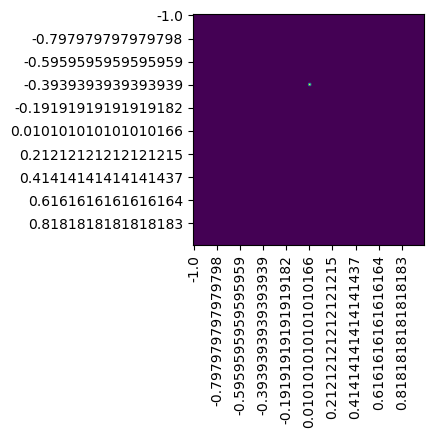

In [26]:
E0 = np.zeros((Nx, Ny))
E0[Nx//2 - 20, Ny//2] = 1
plt.figure(figsize=(3,3))
ax = plt.gca()
plt.imshow(E0)
plt.xticks(np.arange(Nx)[::10], xvec[::10], rotation=90)
plt.yticks(np.arange(Ny)[::10], yvec[::10])
E0 = E0.flatten().astype(complex)

In [27]:
# iflag = -1
# eps = 1e-12
# Fu = finufft.nufft2d3(x / xmax * np.pi, y / ymax  * np.pi, E0, 
#                         fx / (2*fftmaxX) * Nx, fy / (2*fftmaxY) * Ny, 
#                         isign=iflag, eps=eps)
# Eout = finufft.nufft2d3(fx / (2*fftmaxX) * np.pi, fy / (2*fftmaxY) * np.pi, Fu, 
#                         s / xmax * Mx, t / ymax * My,
#                         isign=-iflag, eps=eps).reshape(My, Mx)
# plt.figure(figsize=(3,3))
# plt.xticks(np.arange(Mx)[::10], svec[::10], rotation=90)
# plt.yticks(np.arange(My)[::10], tvec[::10])
# plt.imshow(abs(Eout))

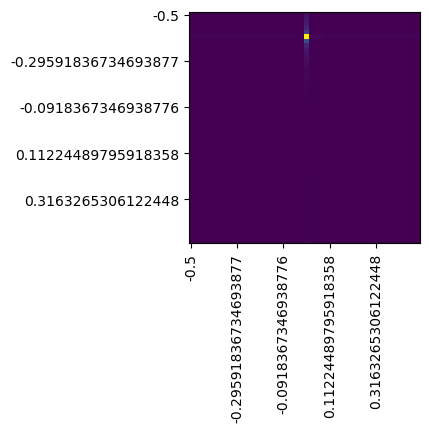

In [28]:
iflag = -1
eps = 1e-12
Fu = finufft.nufft2d3(x / xmax * np.pi, y / ymax * np.pi, E0, 
                        fx * xmax * 2, fy * ymax * 2, 
                        isign=iflag, eps=eps)
Eout = finufft.nufft2d3(fx / (2*fftmaxX) * np.pi, fy / (2*fftmaxY) * np.pi, Fu, 
                        s * (2*fftmaxX) * 2, t * (2*fftmaxX) * 2,
                        isign=-iflag, eps=eps).reshape(My, Mx)
plt.figure(figsize=(3,3))
plt.xticks(np.arange(Mx)[::10], svec[::10], rotation=90)
plt.yticks(np.arange(My)[::10], tvec[::10])
plt.imshow(abs(Eout))

In [29]:
# # number of source points
# M = 100

# # number of target points
# N = 200

# # the source points
# x = 2 * np.pi * np.random.uniform(size=M)
# y = 2 * np.pi * np.random.uniform(size=M)

# # the target points
# s = 2 * np.pi * np.random.uniform(size=N)
# t = 2 * np.pi * np.random.uniform(size=N)

# # their complex strengths
# c = np.zeros(M).astype(np.complex)
# c[M//4] = 1.

# # calcuate the type-3 NUFFT
# f = finufft.nufft2d3(x, y, c, s, t)
# cnew = finufft.nufft2d3(s, t, f, x, y)